# DecoupleR Single Cell Analysis

**Authorship:**
Adam Klie, *10/27/2022*
***
**Description:**
Notebook to run a decoupleR analysis stimulated pancreatic islet multiome data (well just the RNA)
***

# Set-up

In [71]:
import numpy as np
import pandas as pd

import scanpy as sc
import decoupler as dc

import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# Parameters
CELL_TYPES = "beta"  # Meaning α, β, δ in this context
NORMALIZATION = "ND"
GENES = "all"

# Data loading

In [73]:
H5AD_FILE = "/cellar/users/aklie/data/beta_cell_networks/multiomic_stimulated_sc/14sep22_DM023_palmitate_endocrine.h5ad"

In [74]:
adata0 = sc.read_h5ad(H5AD_FILE)
adata0.obsm["X_umap"] = adata0.obsm["UMAP.SCT"]
adata0

AnnData object with n_obs × n_vars = 16342 × 28796
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.2', 'seurat_clusters', 'log_nCount_ATAC', 'log_nCount_SCT', 'log_nFeature_ATAC', 'log_nFeature_SCT', 'nCount_mpeak', 'nFeature_mpeak', 'batch', 'condition', 'time_point', 'sample', 'atac_raw_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_pct.mt', 'TSS.enrichment', 'TSS.percentile', 'mpeak.weight', 'wsnn_res.0.3', 'nCount_peaks', 'nFeature_peaks', 'peaks.weight', 'wsnn_res.0.5', 'nCount_peak', 'nFeature_peak', 'cell.type.1', 'cell.type.2', 'ident'
    obsm: 'HARMONY.SCT', 'UMAP.SCT', 'X_pca', 'X_umap'
    layers: 'logcounts'

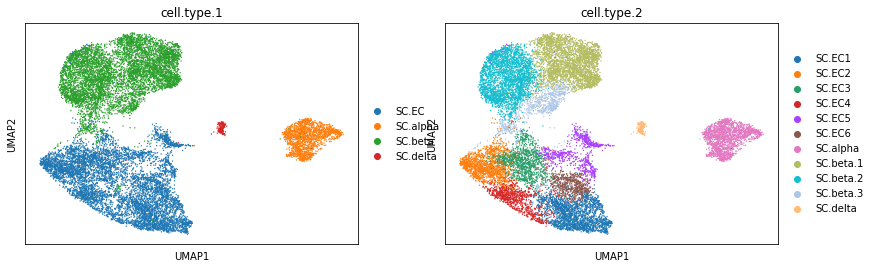

In [75]:
# Double check the umap
sc.pl.umap(adata0, color=['cell.type.1', 'cell.type.2'])

# Prepare data for decoupleR with single cells as samples

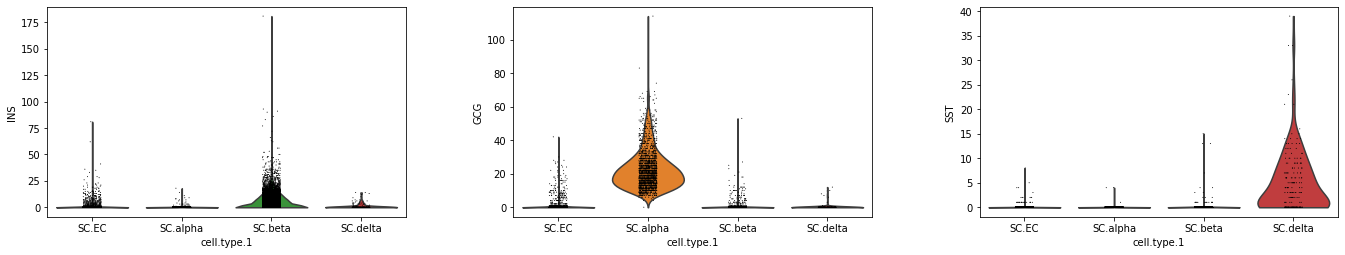

In [76]:
sc.pl.violin(adata0, ['INS', 'GCG', 'SST'], groupby='cell.type.1' )

In [77]:
# Grab only α, β and δ cells
if CELL_TYPES == "all":
    adata = adata0
elif CELL_TYPES == "beta":
    adata = adata0[adata0.obs["cell.type.1"] == "SC.beta"]
elif CELL_TYPES == "alpha":
    adata = adata0[adata0.obs["cell.type.1"] == "SC.alpha"]
elif CELL_TYPES == "delta":
    adata = adata0[adata0.obs["cell.type.1"] == "SC.delta"]
elif CELL_TYPES == "endocrine":
    adata = adata0[adata0.obs["cell.type.1"] == "SC.EC"]

In [78]:
adata.raw = adata

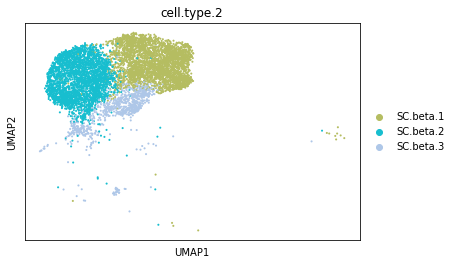

In [79]:
sc.pl.umap(adata, color="cell.type.2")

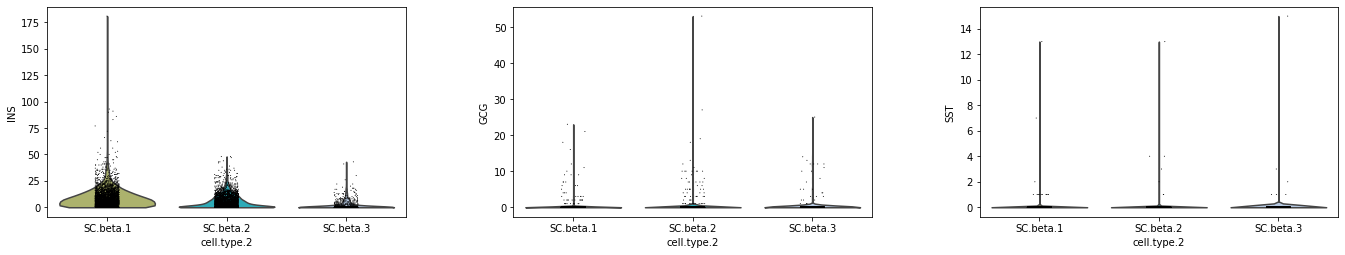

In [80]:
sc.pl.violin(adata, ['INS', 'GCG', 'SST'], groupby='cell.type.2')

In [81]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

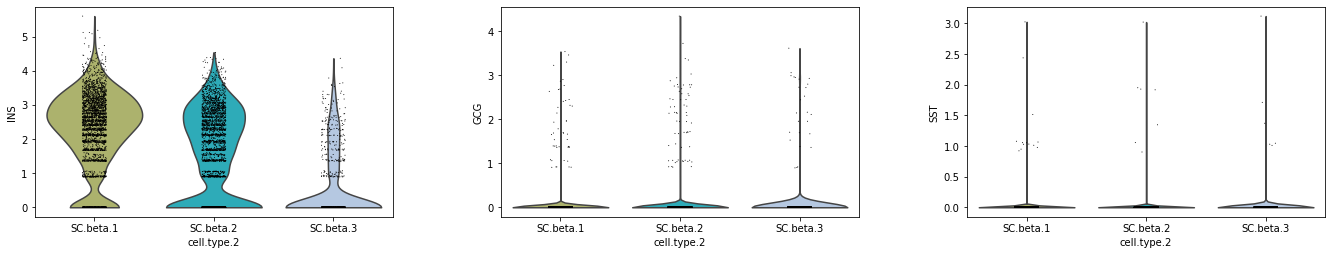

In [82]:
sc.pl.violin(adata, ['INS', 'GCG', 'SST'], groupby='cell.type.2', use_raw=False)

# Pathway activity inference

In [83]:
model = dc.get_progeny(organism='human', top=100)
model

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
1395,p53,CCDC150,-3.174527,7.396252e-13
1396,p53,LCE1A,6.154823,8.475458e-13
1397,p53,TREM2,4.101937,9.739648e-13
1398,p53,GDF9,3.355741,1.087433e-12


In [84]:
dc.run_mlm(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True, use_raw=False)

396 features of mat are empty, they will be removed.
Running mlm on mat with 7042 samples and 28400 targets for 14 sources.


100%|██████████| 1/1 [00:14<00:00, 14.69s/it]


In [85]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')

In [90]:
mean_acts = dc.summarize_acts(acts, groupby='cell.type.2', min_std=0.1)
mean_acts

,Androgen,Estrogen,Hypoxia,JAK-STAT,PI3K,TGFb,Trail,VEGF,WNT
SC.beta.1,1.803313,0.026345,2.098002,-1.576780,0.910062,0.309643,-0.570765,-0.793232,-0.916920
SC.beta.2,1.546082,0.016019,2.775136,-1.375158,0.954069,0.132002,-0.388281,-1.305312,-0.701355
SC.beta.3,1.722882,0.224832,2.073877,-1.645125,1.159098,0.390771,-0.301103,-1.802211,-0.740772


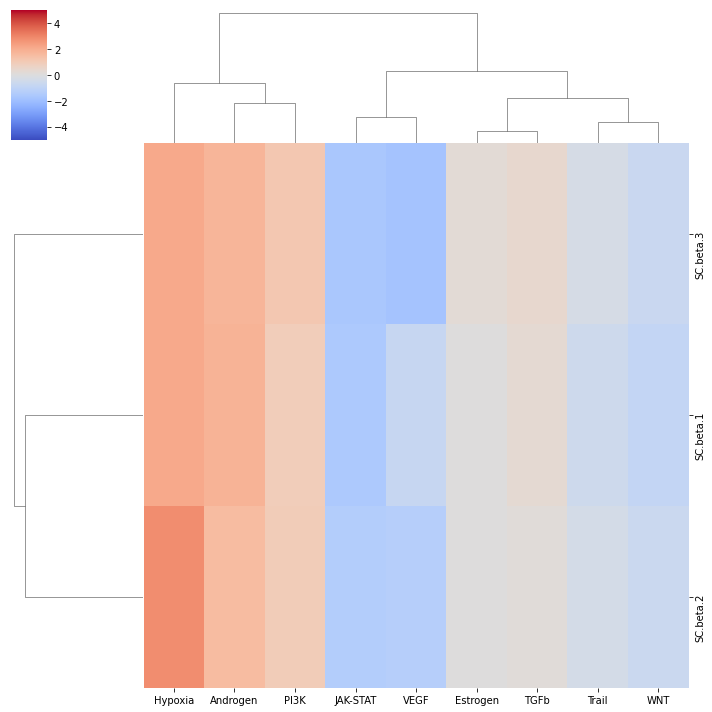

In [91]:
sns.clustermap(mean_acts, xticklabels=mean_acts.columns, vmin=-5, vmax=5, cmap='coolwarm')
plt.show()

# TF Activity Inference

In [93]:
net = dc.get_dorothea(organism='human')
net

,source,confidence,target,weight
0,ETS1,A,IL12B,1.000000
1,RELA,A,IL6,1.000000
2,MITF,A,BCL2A1,-1.000000
3,E2F1,A,TRERF1,1.000000
4,MITF,A,BCL2,1.000000
...,...,...,...,...
32272,IKZF1,C,PTK2B,0.333333
32273,IKZF1,C,PRKCB,0.333333
32274,IKZF1,C,PREX1,0.333333
32275,IRF4,C,SLAMF7,0.333333


In [94]:
dc.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True, use_raw=False)

396 features of mat are empty, they will be removed.
Running mlm on mat with 7042 samples and 28400 targets for 297 sources.


100%|██████████| 1/1 [00:15<00:00, 15.79s/it]


In [95]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')

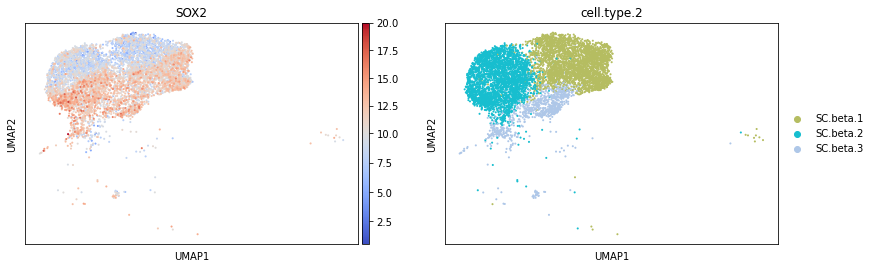

In [111]:
sc.pl.umap(acts, color=['SOX2', 'cell.type.2'], color_map="coolwarm", vcenter=10)

In [105]:
mean_acts = dc.summarize_acts(acts, groupby='cell.type.2', min_std=0.5)
mean_acts

,ATF2,BHLHE22,GATA3,HNF1A,LHX2,MAFB,NEUROD1,PBX3,SOX2,ZNF384
SC.beta.1,2.287033,-0.134542,7.313684,0.991137,3.390800,7.114895,-0.113647,4.293147,9.481828,5.884653
SC.beta.2,1.274573,-0.930065,7.846920,0.931581,2.361335,6.785929,-0.795270,3.386170,9.788743,6.423887
SC.beta.3,1.258779,-1.260247,8.734350,-0.028547,3.375081,6.129409,-1.345111,4.807118,11.055142,5.199993


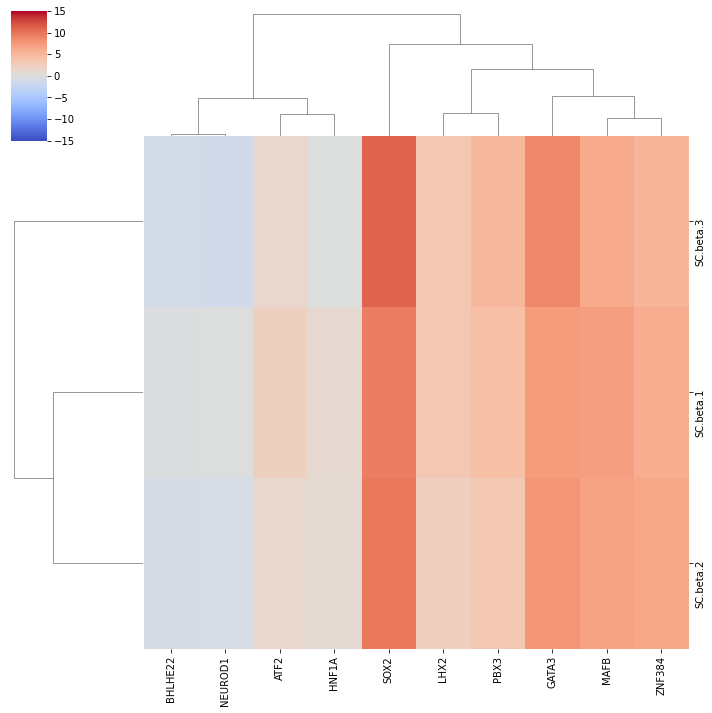

In [108]:
sns.clustermap(mean_acts, xticklabels=mean_acts.columns, vmin=-15, vmax=15, cmap='coolwarm')
plt.show()

---